In [1]:
import json
import re
import collections
import numpy as np
import multiprocessing

import pandas as pd

from pyagender import PyAgender
from io import BytesIO
from PIL import Image
import requests

import cv2

Using TensorFlow backend.


In [2]:
df = pd.read_pickle('named_subject.pkl')

In [3]:
person_per_image = df.groupby('id').named_subject.count()

In [4]:
individual_portraits = person_per_image[person_per_image == 1].index

How many pictures do we have of one person?

In [5]:
df[df.id.isin(individual_portraits)].groupby('named_subject').id.count()

named_subject
Abbatucci, Séverin               5
Abbott, Emma                    50
Abbéma, Louise                  12
Abney, William de Wiveleslie     3
Abott, Bessie                    1
                                ..
Émile                           21
Énault, Louis                    1
Éon, Charles de Beaumont d'      1
Étex, Antoine                    2
Étiévant, Henri                  1
Name: id, Length: 1826, dtype: int64

12 people don't have portraits..

In [6]:
df[df.id.isin(individual_portraits) & df.Portraits].groupby('named_subject').id.count()

named_subject
Abbatucci, Séverin               5
Abbott, Emma                    50
Abbéma, Louise                  12
Abney, William de Wiveleslie     3
Abott, Bessie                    1
                                ..
Émile                           21
Énault, Louis                    1
Éon, Charles de Beaumont d'      1
Étex, Antoine                    2
Étiévant, Henri                  1
Name: id, Length: 1810, dtype: int64

In [17]:
personal_portrait_image = df[df.id.isin(individual_portraits) &\
                             df.Portraits].groupby('named_subject').apply(lambda x: x.id.tolist())
personal_portrait_image = personal_portrait_image.rename('id').reset_index()

In [8]:
def get_image(doc):
    url = doc+'/f1.highres.jpg'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = np.array(img)
    return img

In [18]:
personal_portrait_image

,named_subject,id
0,"Abbatucci, Séverin",[https://gallica.bnf.fr/ark:/12148/btv1b530716...
1,"Abbott, Emma",[https://gallica.bnf.fr/ark:/12148/btv1b531637...
2,"Abbéma, Louise",[https://gallica.bnf.fr/ark:/12148/btv1b530715...
3,"Abney, William de Wiveleslie",[https://gallica.bnf.fr/ark:/12148/btv1b531651...
4,"Abott, Bessie",[https://gallica.bnf.fr/ark:/12148/btv1b531175...
...,...,...
1805,Émile,[https://gallica.bnf.fr/ark:/12148/btv1b530664...
1806,"Énault, Louis",[https://gallica.bnf.fr/ark:/12148/btv1b530653...
1807,"Éon, Charles de Beaumont d'",[https://gallica.bnf.fr/ark:/12148/btv1b530664...
1808,"Étex, Antoine",[https://gallica.bnf.fr/ark:/12148/btv1b531271...


In [ ]:
agender = PyAgender() 

In [60]:
def get_age_gender_estimates(image_docs):
    i = 0
    estimates = []
    
    #handle case where for one image of personn we can't get estimates
    while i < len(image_docs) and len(estimates) == 0:
        img = get_image(image_docs[i])
        retries = 0
        while retries < 5 and len(estimates) == 0:
            estimates = agender.detect_genders_ages(img)
            retries += 1
        i = i+1
        
    if estimates:
        # use first estimate as it is most likely one
        result = estimates[0]
        result['number'] = len(estimates)
        result['id'] = image_docs[i-1]
        return result
    
    return {}

In [65]:
if False:
    age_gender_lables = personal_portrait_image.id.map(get_age_gender_estimates)    

In [67]:
age_gender_lables.to_json('age_gender_labeles.json')

In [66]:
age_gender_lables

0       {'left': 269, 'top': 268, 'right': 748, 'botto...
1       {'left': 433, 'top': 316, 'right': 580, 'botto...
2       {'left': 250, 'top': 718, 'right': 403, 'botto...
3       {'left': 155, 'top': 134, 'right': 872, 'botto...
4       {'left': 415, 'top': 184, 'right': 615, 'botto...
                              ...                        
1805    {'left': 266, 'top': 367, 'right': 641, 'botto...
1806    {'left': 355, 'top': 310, 'right': 596, 'botto...
1807    {'left': 288, 'top': 437, 'right': 583, 'botto...
1808    {'left': 310, 'top': 214, 'right': 739, 'botto...
1809    {'left': 448, 'top': 284, 'right': 601, 'botto...
Name: id, Length: 1810, dtype: object

# evaluation of method


evaluation of algorithm itself is presented on wikipage of py-agender: https://github.com/yu4u/age-gender-estimation

In [69]:
age_gender_lables.map(len).value_counts()

10    1739
0       71
Name: id, dtype: int64

can't get lables for 71 people

In [75]:
personal_portrait_image[age_gender_lables.map(len) == 0]

,named_subject,id
55,Anne,[https://gallica.bnf.fr/ark:/12148/btv1b530924...
66,"Arbell, Lucy",[https://gallica.bnf.fr/ark:/12148/btv1b531189...
114,"Barbot, Andréa",[https://gallica.bnf.fr/ark:/12148/btv1b531071...
193,"Bianchi, Bianca",[https://gallica.bnf.fr/ark:/12148/btv1b531077...
201,"Biéville, Edmond de",[https://gallica.bnf.fr/ark:/12148/btv1b531008...
...,...,...
1663,"Thoré, Théophile",[https://gallica.bnf.fr/ark:/12148/btv1b531044...
1682,"Troyon, Constant",[https://gallica.bnf.fr/ark:/12148/btv1b530665...
1712,"Vaunois, Albert",[https://gallica.bnf.fr/ark:/12148/btv1b531174...
1717,"Ventura, Marie",[https://gallica.bnf.fr/ark:/12148/btv1b531203...


Inspection of 10 images gives two reasons why algorithm doesn't work: images are too dark, profile is from the side, or subject is wearing glasses.

This is an issue with the model and underlying traing data used

In [156]:
personal_portrait_image[age_gender_lables.map(len) == 0].id.map(lambda x: x[-1])

55      https://gallica.bnf.fr/ark:/12148/btv1b53092428m
66      https://gallica.bnf.fr/ark:/12148/btv1b531189234
114     https://gallica.bnf.fr/ark:/12148/btv1b53123824s
193     https://gallica.bnf.fr/ark:/12148/btv1b53144872x
201     https://gallica.bnf.fr/ark:/12148/btv1b53100866p
                              ...                       
1663    https://gallica.bnf.fr/ark:/12148/btv1b531044920
1682    https://gallica.bnf.fr/ark:/12148/btv1b53050843s
1712    https://gallica.bnf.fr/ark:/12148/btv1b53117422f
1717    https://gallica.bnf.fr/ark:/12148/btv1b53120301p
1731    https://gallica.bnf.fr/ark:/12148/btv1b531044619
Name: id, Length: 71, dtype: object

labels that we do get:

In [90]:
df_evaluate = pd.DataFrame(age_gender_lables.tolist())

number of faces that we got:

In [91]:
df_evaluate.number.value_counts()

1.0    1591
2.0     137
3.0       7
4.0       4
Name: number, dtype: int64

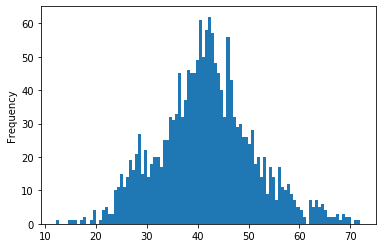

In [96]:
df_evaluate.age.plot(kind='hist', bins=100)

mostly men

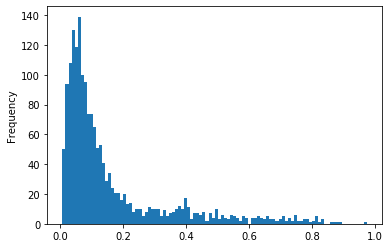

In [97]:
df_evaluate.gender.plot(kind='hist', bins=100)

Clearly, given the name something went wrong

In [134]:
sample = personal_portrait_image[df_evaluate.gender < .5].sample(20)

In [135]:
sample

,named_subject,id
1580,"Saëns, Camille",[https://gallica.bnf.fr/ark:/12148/btv1b531187...
1572,"Sarasate, Pablo de",[https://gallica.bnf.fr/ark:/12148/btv1b530504...
494,"Debussy, Claude",[https://gallica.bnf.fr/ark:/12148/btv1b531188...
1613,"Soltykov, Pierre",[https://gallica.bnf.fr/ark:/12148/btv1b530917...
267,"Brazza, Pierre Savorgnan de",[https://gallica.bnf.fr/ark:/12148/btv1b531598...
911,"Jehin, Blanche",[https://gallica.bnf.fr/ark:/12148/btv1b531878...
1396,Philippe Delmas de,[https://gallica.bnf.fr/ark:/12148/btv1b530660...
1169,"Martinet, Achille Louis",[https://gallica.bnf.fr/ark:/12148/btv1b530505...
1279,"Mérignac, Louis",[https://gallica.bnf.fr/ark:/12148/btv1b531732...
535,"Deschamps, Émile",[https://gallica.bnf.fr/ark:/12148/btv1b531008...


In [136]:
df_evaluate.iloc[sample.index].age

1580    58.115076
1572    28.902806
494     39.104330
1613    45.679063
267     40.332267
911     31.597852
1396    40.838755
1169    43.359087
1279    45.716550
535     47.534167
1261    36.599561
1303    43.009489
1724    40.177861
427     37.353280
944     46.471763
1662    34.385922
1358    41.957517
1694    47.600348
1771    56.442322
1296    30.125953
Name: age, dtype: float64

checking the image, gender predictions seem iffy, but age seems okay! maybe there were not enough old women in the dataset ... 

In [137]:
df_evaluate.iloc[sample.index].id

1580    https://gallica.bnf.fr/ark:/12148/btv1b53118789j
1572    https://gallica.bnf.fr/ark:/12148/btv1b53050476v
494     https://gallica.bnf.fr/ark:/12148/btv1b53118843k
1613    https://gallica.bnf.fr/ark:/12148/btv1b530917809
267     https://gallica.bnf.fr/ark:/12148/btv1b53159810k
911     https://gallica.bnf.fr/ark:/12148/btv1b531878080
1396    https://gallica.bnf.fr/ark:/12148/btv1b530660597
1169    https://gallica.bnf.fr/ark:/12148/btv1b530505248
1279    https://gallica.bnf.fr/ark:/12148/btv1b53173268h
535     https://gallica.bnf.fr/ark:/12148/btv1b53100873r
1261    https://gallica.bnf.fr/ark:/12148/btv1b53173352s
1303    https://gallica.bnf.fr/ark:/12148/btv1b531044045
1724    https://gallica.bnf.fr/ark:/12148/btv1b53079701k
427     https://gallica.bnf.fr/ark:/12148/btv1b530720684
944     https://gallica.bnf.fr/ark:/12148/btv1b530507671
1662    https://gallica.bnf.fr/ark:/12148/btv1b53097509b
1358    https://gallica.bnf.fr/ark:/12148/btv1b53050561k
1694    https://gallica.bnf.fr/

In [114]:
import gender_guesser

In [116]:
import gender_guesser.detector as gender

In [124]:
gender_detector = gender.Detector()

In [139]:
sample.named_subject.map(lambda x: gender_detector.get_gender(x.split(',')[-1]))

1580    unknown
1572    unknown
494     unknown
1613    unknown
267     unknown
911     unknown
1396    unknown
1169    unknown
1279    unknown
535     unknown
1261    unknown
1303    unknown
1724    unknown
427     unknown
944     unknown
1662    unknown
1358       male
1694    unknown
1771    unknown
1296    unknown
Name: named_subject, dtype: object

In [140]:
sample.named_subject.map(lambda x: x.split(',')[-1])

1580                 Camille
1572                Pablo de
494                   Claude
1613                  Pierre
267      Pierre Savorgnan de
911                  Blanche
1396      Philippe Delmas de
1169           Achille Louis
1279                   Louis
535                    Émile
1261                 Gabriel
1303                  Paulin
1724                   Henri
427                     Jean
944                   Joseph
1662                 Francis
1358                    Paul
1694                 Auguste
1771                 Adolphe
1296            Mademoiselle
Name: named_subject, dtype: object

## Example of multiple matches

In [35]:
age_gender_estimates[1564]

[{'left': 124,
  'top': 335,
  'right': 700,
  'bottom': 911,
  'width': 576,
  'height': 576,
  'gender': 0.520518,
  'age': 33.66876730325748},
 {'left': 762,
  'top': 884,
  'right': 903,
  'bottom': 1025,
  'width': 141,
  'height': 141,
  'gender': 0.38889322,
  'age': 38.27217634499539},
 {'left': 109,
  'top': 937,
  'right': 292,
  'bottom': 1120,
  'width': 183,
  'height': 183,
  'gender': 0.33533484,
  'age': 38.98806323923054}]

In [152]:
import matplotlib.pyplot as plt

In [146]:
df_evaluate

,left,top,right,bottom,width,height,gender,age,number,id
0,269.0,268.0,748.0,747.0,479.0,479.0,0.116277,47.741472,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53071608k
1,433.0,316.0,580.0,463.0,147.0,147.0,0.585720,27.465579,2.0,https://gallica.bnf.fr/ark:/12148/btv1b531622212
2,250.0,718.0,403.0,871.0,153.0,153.0,0.377803,40.358822,3.0,https://gallica.bnf.fr/ark:/12148/btv1b53071525p
3,155.0,134.0,872.0,851.0,717.0,717.0,0.104841,44.487285,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53165139q
4,415.0,184.0,615.0,384.0,200.0,200.0,0.389818,27.194442,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53117510h
...,...,...,...,...,...,...,...,...,...,...
1805,266.0,367.0,641.0,742.0,375.0,375.0,0.011937,42.445805,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53066482v
1806,355.0,310.0,596.0,551.0,241.0,241.0,0.033713,45.716630,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53065399p
1807,288.0,437.0,583.0,732.0,295.0,295.0,0.358721,26.078685,1.0,https://gallica.bnf.fr/ark:/12148/btv1b530664193
1808,310.0,214.0,739.0,643.0,429.0,429.0,0.108013,47.732863,1.0,https://gallica.bnf.fr/ark:/12148/btv1b531271467


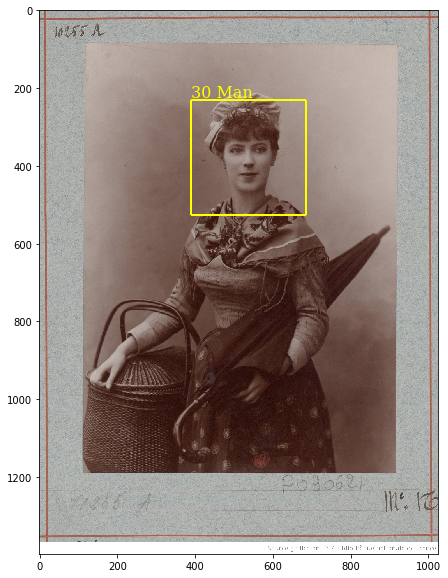

In [153]:
font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 16,
        }
img = get_image(df_evaluate.id[1296])

for detect in [age_gender_lables[1296]]:
    gender =  'Woman' if detect['gender'] > .5 else 'Man'
    plt.figure(figsize=(10, 10))
    plt.text(detect['left'], detect['top']-10, str(detect['age'])[:2] + ' ' + gender, fontdict=font)
    plt.imshow(cv2.rectangle(img, (detect['left'], detect['top']), (detect['right'], detect['bottom']), (255, 255, 0), 3))